# Parameter estimation with emcee 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Initializing-data" data-toc-modified-id="Initializing-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initializing data</a></span></li><li><span><a href="#Getting-a-feel-with-plots" data-toc-modified-id="Getting-a-feel-with-plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Getting a feel with plots</a></span></li><li><span><a href="#Using-sympy-to-evaluate-the-integral" data-toc-modified-id="Using-sympy-to-evaluate-the-integral-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Using sympy to evaluate the integral</a></span></li><li><span><a href="#MCMC-Hammer-(emcee)" data-toc-modified-id="MCMC-Hammer-(emcee)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>MCMC Hammer (emcee)</a></span><ul class="toc-item"><li><span><a href="#Log-likelihood-function" data-toc-modified-id="Log-likelihood-function-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Log likelihood function</a></span></li><li><span><a href="#Log-prior" data-toc-modified-id="Log-prior-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Log prior</a></span></li><li><span><a href="#Log-probability-function" data-toc-modified-id="Log-probability-function-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Log probability function</a></span></li><li><span><a href="#Maximum-likelihood-parameter-estimation" data-toc-modified-id="Maximum-likelihood-parameter-estimation-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Maximum likelihood parameter estimation</a></span></li><li><span><a href="#Run-emcee" data-toc-modified-id="Run-emcee-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Run emcee</a></span></li><li><span><a href="#Corner-plot" data-toc-modified-id="Corner-plot-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Corner plot</a></span></li></ul></li><li><span><a href="#Final-numbers" data-toc-modified-id="Final-numbers-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Final numbers</a></span></li></ul></div>

## Libraries

In [1]:
# Standard imports 
import numpy as np
import os 
import sys 
print("Python %s.%s.%s"%sys.version_info[:3])

# Emcee imports 
import scipy.stats
import emcee
print("emcee version", emcee.__version__)
from IPython.display import display, HTML
%config InlineBackend.figure_format ='retina'

# Plotting imports 
import corner
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from jupyterthemes import jtplot
jtplot.style(theme='monokai')
jtplot.style(ticks = True, grid = False, figsize = (10,8))

Python 3.6.4
emcee version 3.0rc2


## Initializing data 

Data created from the following function, 

\begin{equation*}
y(x1,x2) = \int^{x1}_0 \textrm{sin}(A\zeta + Bx_2)(C\zeta^2 + \textrm{ln}(Dx_2)) d\zeta.
\end{equation*}

The given dataset contains data for $x1$, $x2$, $y$, and $\sigma_y$ (the standard error in y). Guesses for the four parameters are obtained using a random number between zero and five. 

NOTE: This notebook uses the datafile: fake2.dat

In [2]:
#  import data
data = np.loadtxt( 'fake2.dat' )

In [3]:
var1 = data[0:,0]
var2 = data[0:,1]
var3 = data[0:,2]
var4 = data[0:,3]

x1 = np.copy(var1)
x2 = np.copy(var2)
y = np.copy(var3)
yerr = np.copy(var4)

a_approx = np.random.uniform(0,5)  
b_approx = np.random.uniform(0,5)  
c_approx = np.random.uniform(0,5) 
d_approx = np.random.uniform(0,5) 

print("Guesses:")
print("a = {0:0.3f}".format(a_approx))
print("b = {0:0.3f}".format(b_approx))
print("c = {0:0.3f}".format(c_approx)) 
print("d = {0:0.3f}".format(d_approx)) 

Guesses:
a = 1.240
b = 3.928
c = 0.966
d = 2.672


## Getting a feel with plots

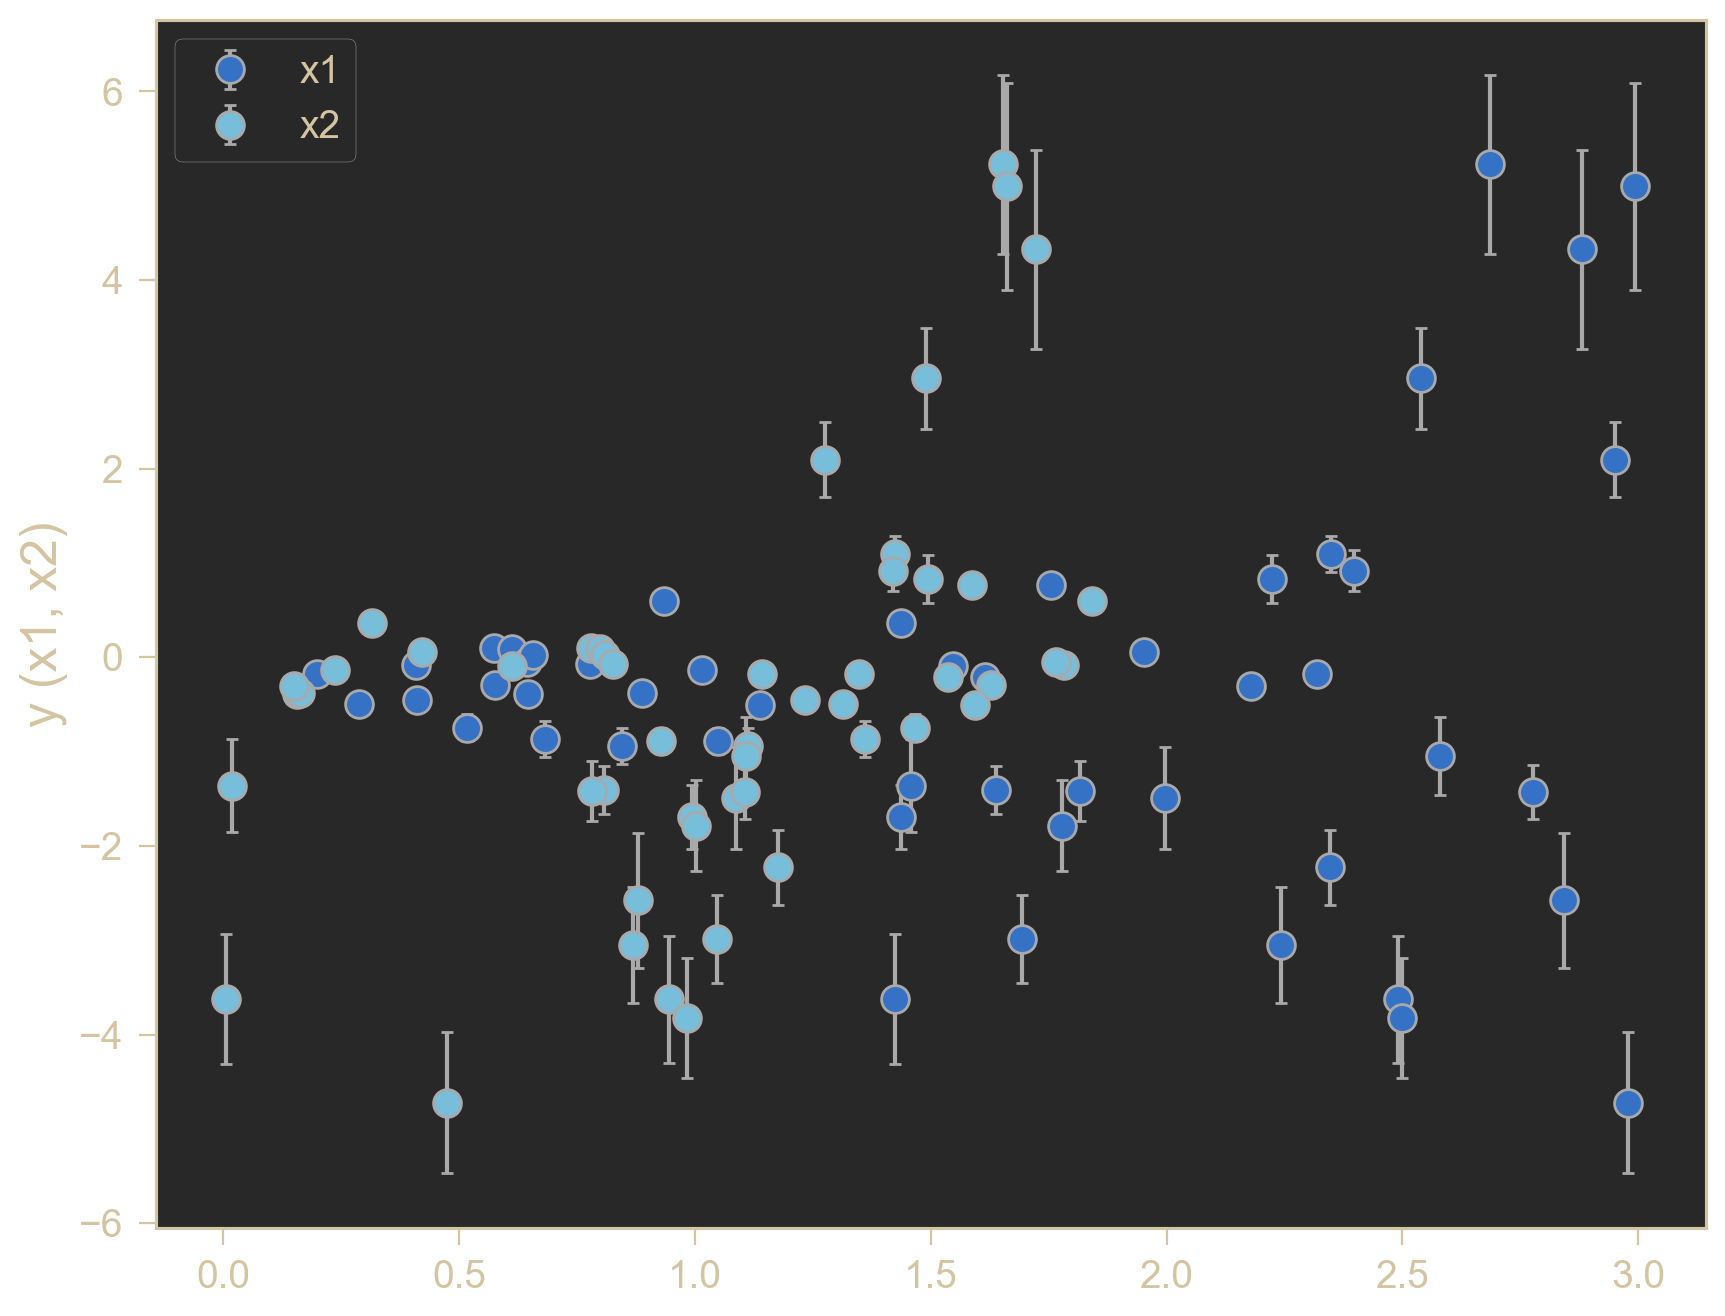

In [4]:
plt.figure(figsize=(10,8), dpi = 100)
plt.errorbar(x1,y,yerr=yerr, fmt=".b", markersize = 20, markeredgecolor = 'darkgrey', ecolor='darkgrey', capsize=2, elinewidth=1.5, markeredgewidth=1, alpha = 1)
plt.errorbar(x2,y,yerr=yerr, fmt=".c", markersize = 20, markeredgecolor = 'darkgrey', ecolor='darkgrey', capsize=2, elinewidth=1.5, markeredgewidth=1)

plt.legend(["x1", "x2"], fontsize=14)
plt.ylabel("y (x1, x2)", fontsize= 18, rotation = 90)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.show()

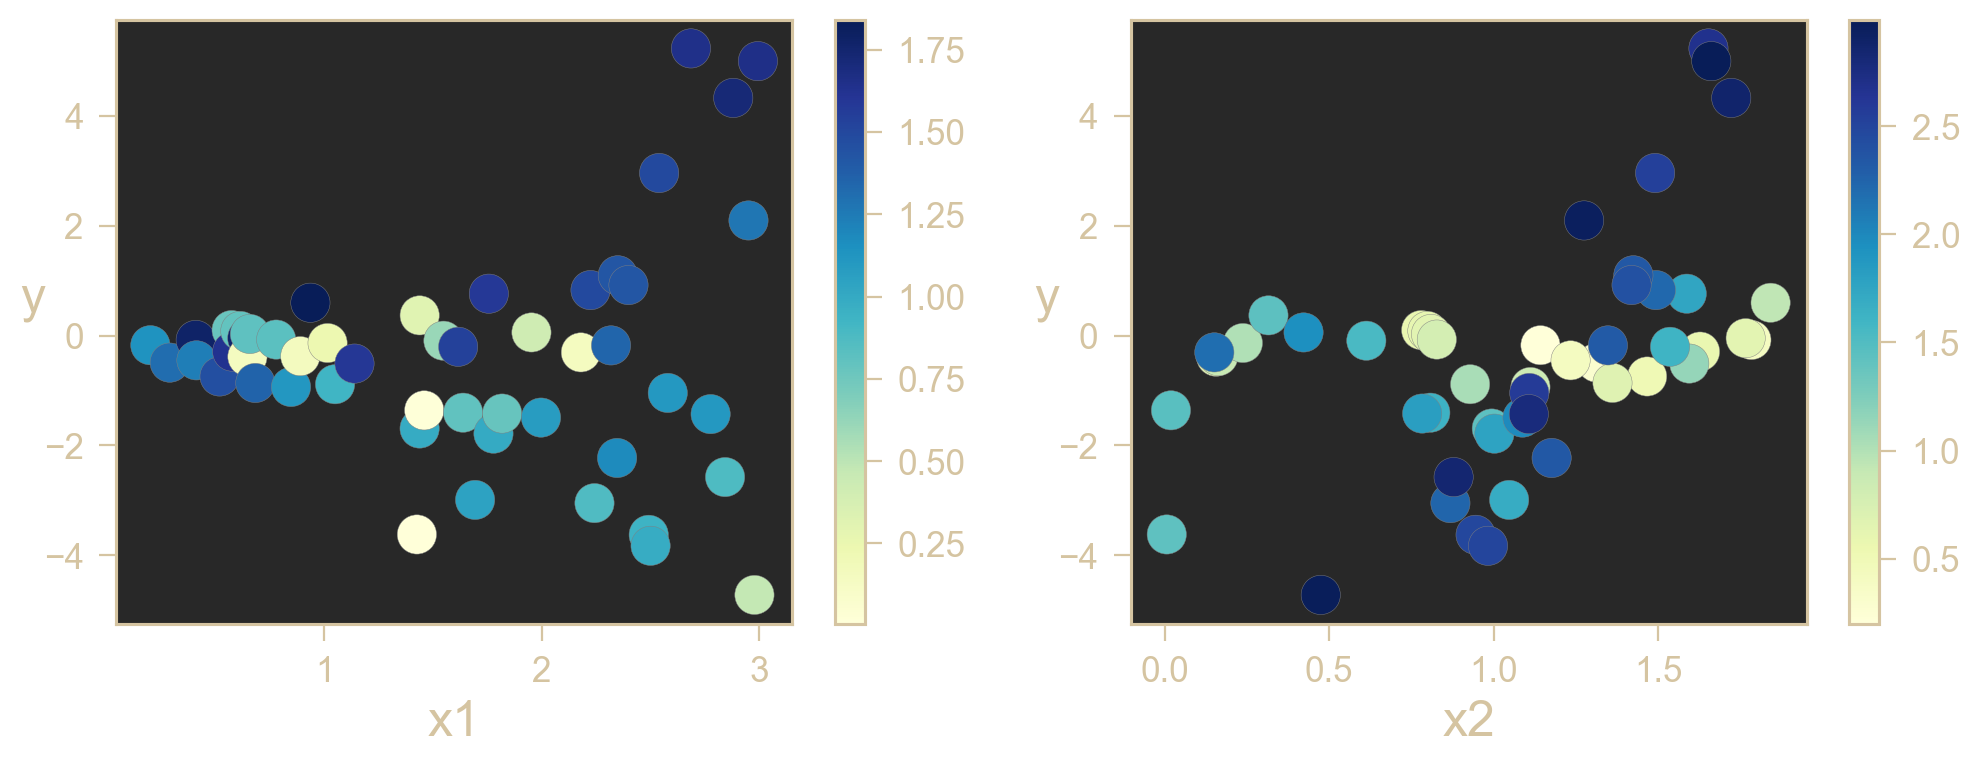

In [5]:
cm = plt.cm.get_cmap('YlGnBu')
plt.figure(figsize=(12,4), dpi = 100)
plt.subplot(1,2,1)
plt.scatter(x1, y, c=x2, s=200, marker='o', edgecolor = 'gray', cmap=cm)
plt.colorbar()
plt.xlabel('x1', fontsize = 18)
plt.ylabel('y', fontsize = 18, rotation = 0)

plt.subplot(1,2,2)
plt.scatter(x2, y, c=x1, s=200, marker='o', edgecolor = 'gray', cmap=cm)
plt.colorbar()
plt.xlabel('x2', fontsize = 18)
plt.ylabel('y', fontsize = 18, rotation = 0)

plt.show()

## Using sympy to evaluate the integral 

Sympy enables the user to evaluate an integral symbolically, then using lambdify we turn it into a numpy function which can then be computed by the functions below. 

In [6]:
import sympy as sym

x1, x2, a, b, c, d, x = sym.symbols('x1, x2, a, b, c, d, x')
f = sym.sin(a*x + b * x2) * (c*x**2 + sym.ln(d*x2))  
yx1x2 = sym.integrate(f, (x, 0, x1))  
 
f_mod = sym.lambdify( (x1, x2, a, b, c, d, x), yx1x2, 'numpy')

## MCMC Hammer (emcee)

### Log likelihood function

The likelihood function expresses the probability of a set of observations given a set of parameters. Here, we are taking the log of the function for computational convenience (multiplication is more expensive than addition). 

\begin{equation}
\textrm{ln} p(y|x,\sigma_y, \theta) = \frac{1}{2} \sum_n \left[ \frac{(y - \textrm{model})^2}{s_n^2} + ln(2\pi s_n^2)\right],
\end{equation}

where 

\begin{equation}
s_n^2 = \sigma_y^2,
\end{equation}

and $\theta$ is the set of parameters in our problem.

This function is later minimized using the scipy.optimize module. 

NOTE: In this problem, we are not assuming our uncertainties (yerr) are underestimated, and so have removed the f term. 

In [7]:
def log_likelihood(theta, x1, x2, y, yerr, f_mod): 
    a, b, c, d = theta
    model =  f_mod
    return -0.5 * np.sum(((y-model(x1, x2, a ,b, c, d, x))**2/yerr**2)) 

### Log prior

In Bayesian statistics, a posterior probability is the probability of an observation occuring given some prior information (i.e., some prior probability). 

Bayes' Theorem states,

\begin{equation}
P(A|B)  = \frac{P(A)P(B|A)}{P(B)} ,
\end{equation}

thus the probability of A being observed given B depends on: 
- the probability A based on prior observations,
- the probability of B based on prior observations,
- and the probability of B given A.

For our purposes, the likelihood function can be approximated to, 

\begin{equation}
p(\theta|x,y,\sigma_y) \propto p(\theta)p(y|x, \sigma_y, \theta),
\end{equation}

where 

\begin{equation}
p(\theta),
\end{equation}

is our prior function. We will use acceptable ranges as previous knowledge for our parameters.

In [8]:
def log_prior(theta): 
    a, b, c, d = theta
    if (-1.0 < a < 5.0 and -1.0 < b < 5.0 and \
        -1.0 < c < 5.0 and -1.0 < d < 5.0):
        return 0.0
    return -np.inf

### Log probability function
Putting our log- prior and likelihood functions together, we get our log-probability function: 

\begin{equation}
\textrm{ln} p(\theta, x,y,\sigma_y) = p(\theta) + \frac{1}{2} \sum_n \left[ \frac{(y - \textrm{model})^2}{s_n^2} + ln(2\pi s_n^2)\right].
\end{equation}

This is the distribution we will later sample with emcee. 

In [9]:
def log_probability(theta, x1, x2, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x1, x2, y, yerr, f_mod)

### Maximum likelihood parameter estimation

Using the basinhopping algorithm along with the L-BFGS-B method to find global minimum of the log likelihood function (i.e., maximum likelihood).  

In [10]:
import emcee 
from scipy.optimize import minimize
from scipy.optimize import basinhopping

x1 = np.copy(var1)
x2 = np.copy(var2)
y = np.copy(var3)
yerr = np.copy(var4)
initial = np.array([a_approx, b_approx, c_approx, d_approx]) + 2* np.random.randn(4)
n11 = lambda *args: -log_likelihood(*args)
bounds = ((0.5,5), (0.5,5), (0.5,5), (0.5,5))
minimizer_kwargs = dict(method="L-BFGS-B", args = (x1, x2, y, yerr, f_mod), bounds = bounds, tol = 1e-4)
soln = basinhopping(n11, initial, T= 5, stepsize =0.9, niter = 500, 
                    minimizer_kwargs=minimizer_kwargs) 
print(soln)

a_ml, b_ml, c_ml, d_ml = soln.x

                        fun: 664.47621121253587
 lowest_optimization_result:       fun: 664.47621121253587
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.50421963e-03,   1.22440724e-02,   4.54614622e+02,
        -2.92175173e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 65
      nit: 10
   status: 0
  success: True
        x: array([ 4.42716431,  2.58618246,  0.5       ,  0.9131786 ])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 31405
                        nit: 500
                          x: array([ 4.42716431,  2.58618246,  0.5       ,  0.9131786 ])


### Run emcee

Initializing walkers in a Gaussian ball around ML estimates.

In [11]:
pos = soln.x + 1e-2 * np.random.randn(200,4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x1, x2, y, yerr)
)
sampler.run_mcmc(pos, 2000)
samples = sampler.chain[:, :, :].reshape((-1,ndim))

### Corner plot

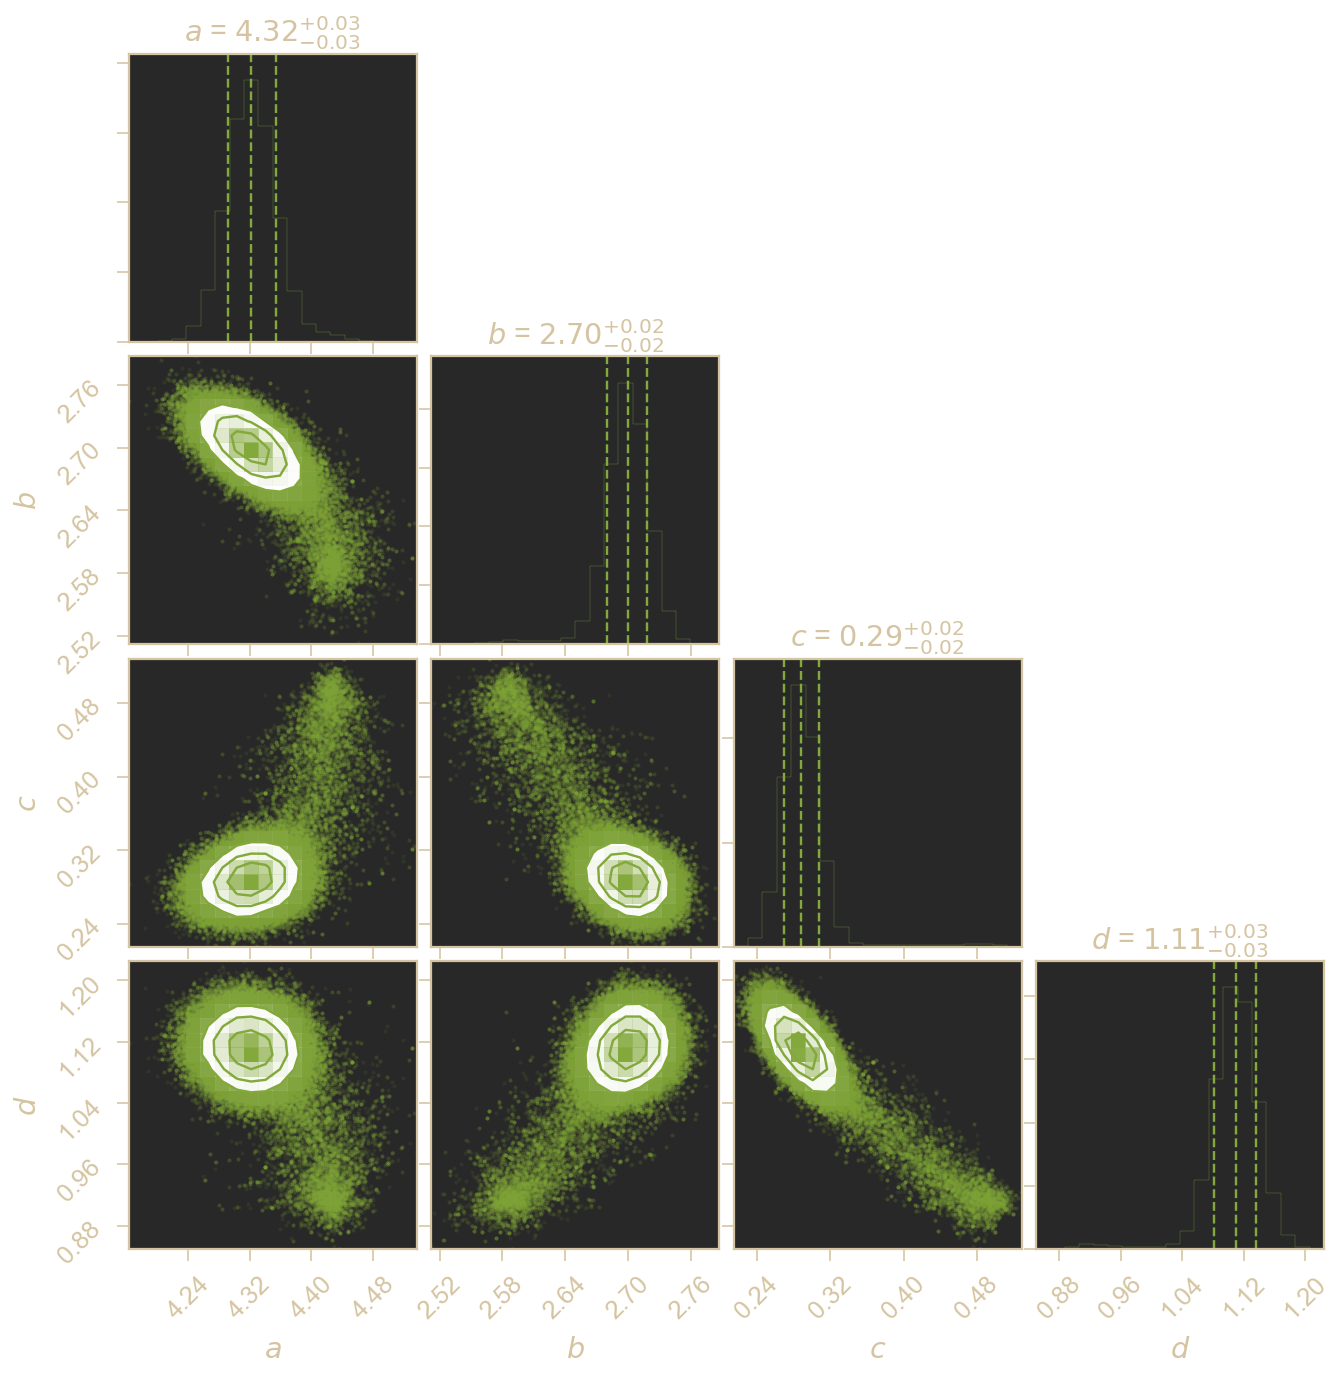

In [12]:
fig = corner.corner(samples, labels=["$a$", "$b$", "$c$", "$d$","$\ln\,f$"], color = 'g', 
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, figsize=(10,10))
#fig.savefig("corner_plot.png")

## Final numbers

In [13]:
a_mcmc, b_mcmc, c_mcmc, d_mcmc = map(
    lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
    zip(*np.percentile(samples, [16, 50, 84], axis=0))
)

In [14]:
print("MCMC estimates:")
print("a = ",a_mcmc[0], ",", "+", a_mcmc[1], ",", "-", a_mcmc[2]) 
print("b = ",b_mcmc[0], ",", "+", b_mcmc[1], ",", "-", b_mcmc[2]) 
print("c = ",c_mcmc[0], ",", "+", c_mcmc[1], ",", "-", c_mcmc[2]) 
print("d = ",d_mcmc[0], ",", "+", d_mcmc[1], ",", "-", d_mcmc[2]) 
print("---------------------")
print("Initial guesses:")
print("a = {0:0.3f}".format(a_approx))
print("b = {0:0.3f}".format(b_approx))
print("c = {0:0.3f}".format(c_approx)) 
print("d = {0:0.3f}".format(d_approx)) 
print("---------------------")
print("Maximum likelihood estimates:")
print("a = {0:0.3f}".format(a_ml))
print("b = {0:0.3f}".format(b_ml))
print("c = {0:0.3f}".format(c_ml)) 
print("d = {0:0.3f}".format(d_ml)) 


MCMC estimates:
a =  4.32207062858 , + 0.0319310403523 , - 0.0307226888743
b =  2.69972590249 , + 0.0189430357934 , - 0.0200384182361
c =  0.288464714026 , + 0.0197574897378 , - 0.0186715770586
d =  1.10955318009 , + 0.0272103509104 , - 0.0281775906232
---------------------
Initial guesses:
a = 1.240
b = 3.928
c = 0.966
d = 2.672
---------------------
Maximum likelihood estimates:
a = 4.427
b = 2.586
c = 0.500
d = 0.913
